**AKNOUCHE ANIS : 28616923**

**HADDADI HACENE : 3801659**


#**Configuration de Spark :**

In [1]:
!pip install -q pyspark
!pip install -q findspark

     |████████████████████████████████| 281.3 MB 33 kB/s 
     |████████████████████████████████| 198 kB 49.2 MB/s 


In [2]:
import os
# !find /usr/local -name "pyspark"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.7/dist-packages/pyspark"
os.environ["JAVA_HOME"] = "/usr"

In [3]:
# Principaux import
import findspark
from pyspark.sql import SparkSession 
from pyspark import SparkConf  

# pour les dataframe et udf
from pyspark.sql import *  
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import *

# pour le chronomètre
import time

# initialise les variables d'environnement pour spark
findspark.init()

# Démarrage session spark 
# --------------------------
def demarrer_spark():
  local = "local[*]"
  appName = "TP"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "6G").\
  set("spark.driver.memory","6G").\
  set("spark.sql.catalogImplementation","in-memory")
  
  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")
  
  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (4 coeurs)
  spark.conf.set("spark.sql.shuffle.partitions","4")    
  print("session démarrée, son id est ", sc.applicationId)
  return spark
spark = demarrer_spark()

session démarrée, son id est  local-1637573290395


In [4]:
# on utilise 8 partitions au lieu de 200 par défaut
spark.conf.set("spark.sql.shuffle.partitions", "8")
print("Nombre de partitions utilisées : ", spark.conf.get("spark.sql.shuffle.partitions"))

Nombre de partitions utilisées :  8


# **Chargement des données :**

In [6]:
import pandas as pd
data = pd.read_csv("housing_data.csv")
data = spark.createDataFrame(data)
data.show()

+----------+----------+--------------------+------------+--------------------+-----+---------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+--------------------+--------------------+-------+-------------------+-----+
|Unnamed: 0|        id|                 url|      region|          region_url|price|     type|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|laundry_options|   parking_options|           image_url|         description|    lat|               long|state|
+----------+----------+--------------------+------------+--------------------+-----+---------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+--------------------+--------------------+-------+-------------------+-----+
|         0|7049044568|https

## Présentation du dataset:

Le dataset utilisé dans ce projet est: Housing, ce dernier recense les locations de maisons aux Etats-Unis.

Ce dataset est composé de 22 colonnes :

* **id** :  l'id de la vente
* **url** : L'url de l'annonce sur le site craiglist
* **region**: La région où se situe la maison
* **region_url** : L'url de la region sur le site craiglist
* **price** : Le prix de location par mois
* **type** : L'un des types de maisons suivants :
  * manufactured
  * in-law
  * house
  * Apartment
  * townhouse
  * flat
  * loft
  * duplex
  * cottage/cabin
  * condo
* **sqfeet** : La surface de la maison
* **beds** : Le nombre de chambres
* **baths** : Le nombre de salle de bains
* **cats_allowed** : Tolérence ou non des chats (champs booléen)
* **dogs_allowed** : Tolérence ou non des chiens (champs booléen)
* **smoking_allowed** : Tolérence ou non de la cigarette (champs booléen)
* **wheelchair_access** : Possession ou non d'un accèes handicapé (champs booléen)
* **electric_vehicle_charge** : Possession ou non d'une prise de recharge pour véhicule éléctrique (champs booléen)
* **comes_furnished** : Maison meublée ou non (champs booléen)
* **laundry_options** : L'option de la buanderie parmis les options suivantes:
  * laundry in bldg
  * no laundry on site
  * w/d hookups
  * laundry on site
  * w/d in unit
* **parking_options** :  L'option du parking parmis les options suivantes:
  * carport
  * no parking
  * street parking
  * attached garage
  * detached garage
  * valet parking
  * off-street parking
* **image_url** : L'url de l'image de la maison
* **description** : Description de la maison
* **lat** : Latitude de la localisation de la maison
* **long** : Longitude de la localisation de la maison
* **state** : Etat où se situe la maison.


*Ce dataset possède 375k rows, pour respecter l'énnoncé et utiliser un dataset avec une taille d'environ 10mb, on n'utilisera que 10k rows du dataset, on selectionnera notamment ceux avec des champs non null, on ajoutera une colonne Unnamed 0 qui correspond au numéro du rows dans le dataset.*

**Remraque**:
Une fois le dataset housing_data importé et mit sous forme d'un dataframe spark, on l'affiche et on remarque que ce dernier possède des colonnes qui ne serviront pas dans notre tâche de ML car ils contiennent des id, url et description textuelle. On peut donc d'ores et déjà les supprimer.

Les colonnes à supprimer sont les suivants :
* id
* url
* region_url
* image_url
* description

La colonne 'Unnamed: 0' représentera le nouvel id de notre dataset

In [7]:
#Columns to remove
cols = ('id', 'url', 'region_url', 'image_url', 'description')
data = data.drop(*cols)

#Renomme la colonne 'Unnamed: 0' en 'id'
data = data.withColumnRenamed('Unnamed: 0','id')

data.printSchema()
data.show()

root
 |-- id: long (nullable = true)
 |-- region: string (nullable = true)
 |-- price: long (nullable = true)
 |-- type: string (nullable = true)
 |-- sqfeet: long (nullable = true)
 |-- beds: long (nullable = true)
 |-- baths: double (nullable = true)
 |-- cats_allowed: long (nullable = true)
 |-- dogs_allowed: long (nullable = true)
 |-- smoking_allowed: long (nullable = true)
 |-- wheelchair_access: long (nullable = true)
 |-- electric_vehicle_charge: long (nullable = true)
 |-- comes_furnished: long (nullable = true)
 |-- laundry_options: string (nullable = true)
 |-- parking_options: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long: double (nullable = true)
 |-- state: string (nullable = true)

+---+------------+-----+---------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+---------------+------------------+-------+-------------------+-----+
| id|      region|price|     type|sqfeet|beds|ba

# Statistiques :
Nous allons ici nous intéresser à quelques statistiques et descriptions de nos données pour une première prise en main.

### Describe de quelques colonnes du dataset 

In [8]:
#Statistiques
colsDescribe=['price', 'sqfeet', 'beds', 'baths', 'lat', 'long']

def describe_(col):
    print("Describe de la colonne : ",col)
    data.select(col).describe().show()
    
for c in colsDescribe:
  describe_(c)

Describe de la colonne :  price
+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|            10000|
|   mean|        2204.9507|
| stddev|7184.259519167814|
|    min|                0|
|    max|           704873|
+-------+-----------------+

Describe de la colonne :  sqfeet
+-------+------------------+
|summary|            sqfeet|
+-------+------------------+
|  count|             10000|
|   mean|         1213.8696|
| stddev|14478.445109233033|
|    min|                 1|
|    max|           1019856|
+-------+------------------+

Describe de la colonne :  beds
+-------+------------------+
|summary|              beds|
+-------+------------------+
|  count|             10000|
|   mean|            1.8168|
| stddev|0.8886600765608673|
|    min|                 0|
|    max|                 7|
+-------+------------------+

Describe de la colonne :  baths
+-------+------------------+
|summary|             baths|
+-------+------------------+
|  count

**Remarque** 

Les describe nous permettent d'obtenir pour chaque colonne avec des données numérique la moyenne, l'ecart type, le min et le max de ses valeurs ce qui est un premier pas important dans la prise en main des données

On affiche ci-dessous les diagrammes en violon des colonnes avec des données numériques, ces derniers contiennent une boite à moustache ainsi que la densité de distribution pour chacune des colonnes suivantes : ['price', 'sqfeet', 'beds', 'baths', 'lat', 'long']


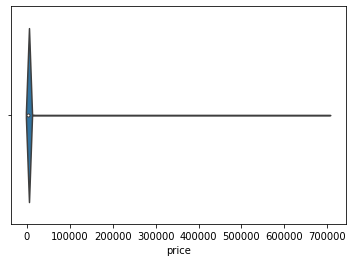

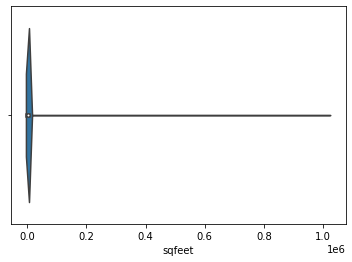

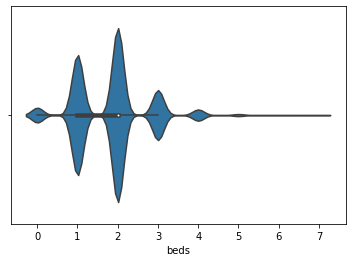

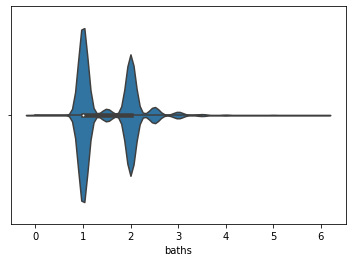

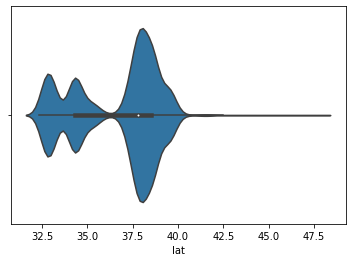

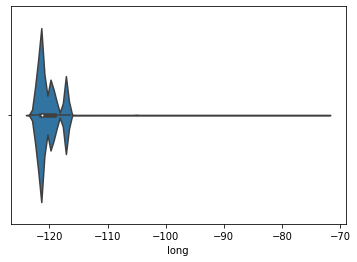

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
for col in colsDescribe:
  plt.figure()
  ax = sns.violinplot(x=data.toPandas()[col])

**Remarque**: 

En analysant les digramme de '*price*' et de '*sqfeet*' on peut remarquer que des outliers sont présents, des valeurs qui ne suivent pas la distribution des données 
Affichant le nombre de rows avec un prix **supérieur à 10k $** et avec une sureface sqfeet **supérieur à 10000** 

In [9]:
print("Le nombre de maison avec un prix>10k et un sqfeet>10k est :",data.filter((data.price>10000) & (data.sqfeet>10000)).count(), 'maison(s)')

Le nombre de maison avec un prix>10k et un sqfeet>10k est : 1 maison(s)


On peut voir qu'une seule maison correspond à ces critères, on peut donc considérer qu'elle n'apporte pas de réel information et la supprimer. Affichant par la suite de nouveau les diagrammes en violon de *price* et *sqfeet*

In [10]:
data=data.filter((data.price<=10000) & (data.sqfeet<=10000))

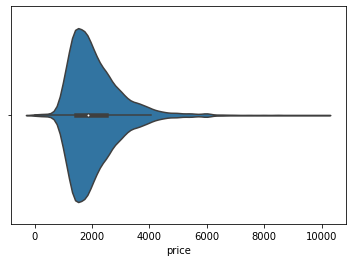

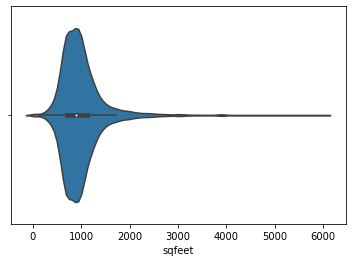

In [12]:
for col in ['price','sqfeet']:
  plt.figure()
  ax = sns.violinplot(x=data.toPandas()[col])

**Remarque** :

On obtient ici des diagrammes plus lisibles avec un bon apperçu de la distribution des données pour *'price'* et *'sqfeet'*

### Histogrammes des occurences en fonctions des valeurs de chaque colonne:

On affiche ici le nombre d'éléments pour chaque valeur possible pour les colonnes avec une faible variance

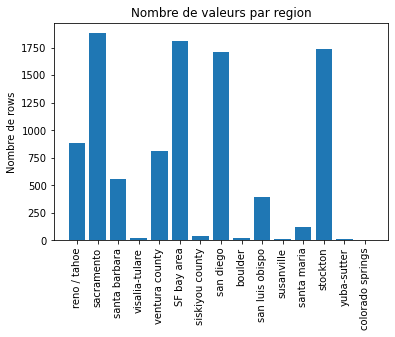

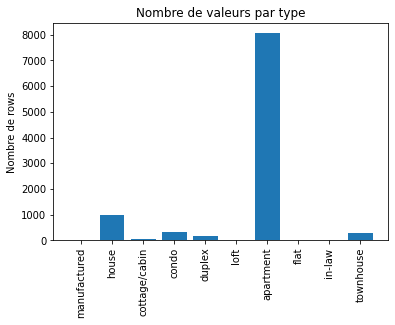

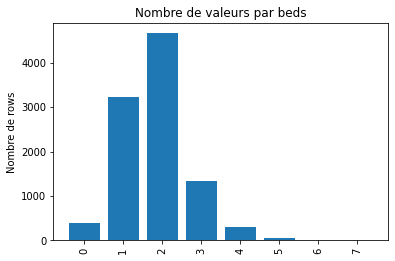

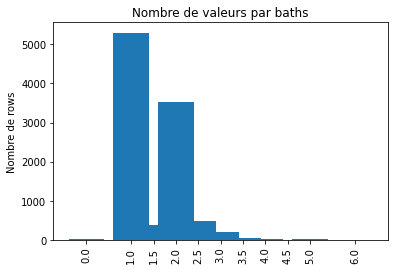

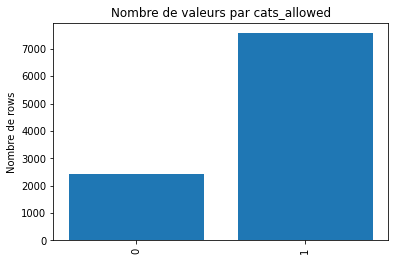

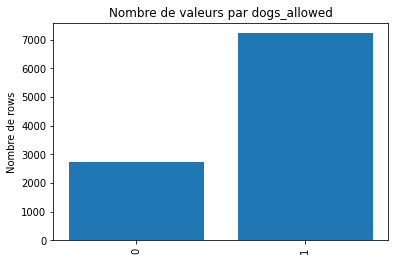

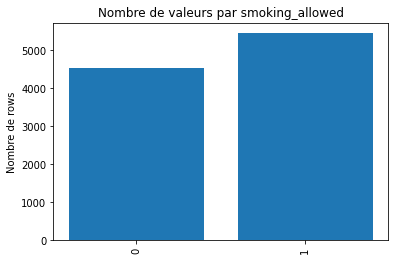

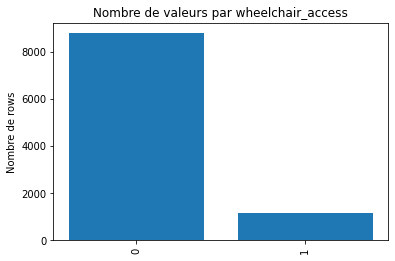

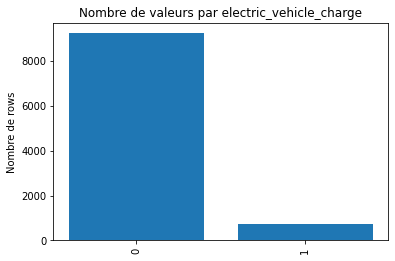

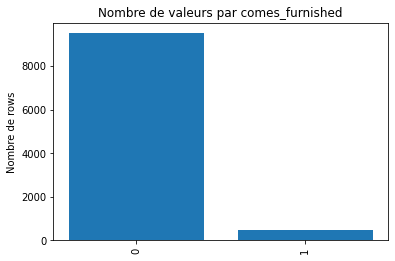

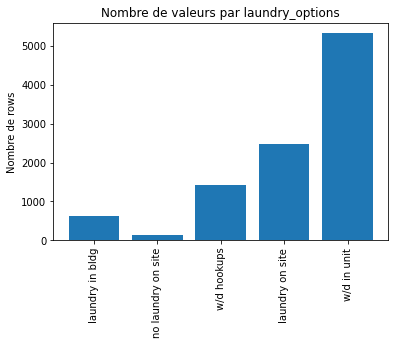

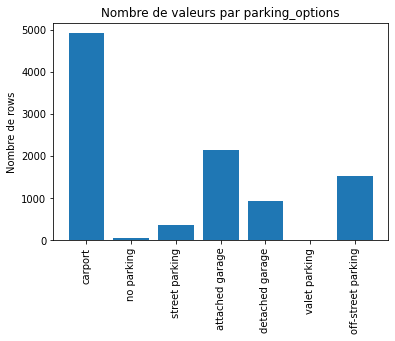

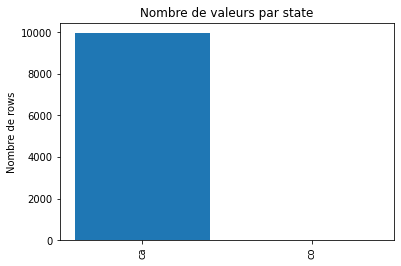

In [13]:
import pandas as pd
colsCount=['region', 'type', 'beds', 'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed', 'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished', 'laundry_options', 'parking_options', 'state']

def count_(col):
    df=data.select(col).groupBy(col).count().toPandas()
    plt.figure()
    plt.bar(df[col],df["count"])
    plt.xticks(ticks=df[col].values.tolist(),rotation=90)
    plt.title("Nombre de valeurs par "+col)
    plt.ylabel("Nombre de rows")
for c in colsCount:
    count_(c)

**Remarque**:

On remarque une certaine disparité entre les valeurs sur les différentes colonnes

Par exemple pour la colonne *'state'* la valeur *'co'* n'est quasi pas représenté.



### Matrice de corrélation :

La matrice de corrélation permet de mettre en évidence les colonnes qui sont corrélées entre elles.

La première utilisation possible est le fait de trouver les colonnes fortement corrélées entre-elles et d'en laisser qu'une seule car les autres n'apportent pas d'information.


En second lieu, comme notre but dans ce projet est de prédire le prix des maisons, il peut-être utile de trouver des features très corrélées au prix, ce qui permettera de leurs donner plus d'importance lors de la décision.

**Remarque** : 

Pour pouvoir calculer la matrice de corrélation, nous devons transformer les valeurs catégorielles en nombres, nous opterons donc pour une indexation de ces dernières.

Nous ne prendrons pas en compte l'id qui n'apporte pas d'information.

#Numérisation de variables catégorielles

In [11]:
#Numerisation

from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

columns = ['region', 'type', 'laundry_options', 'parking_options', 'state']
stages = []

for col in columns:
    stages.append(StringIndexer( inputCol = col, outputCol = 'indexed_'+col))


pipeline = Pipeline(stages = stages)
data_indexed = pipeline.fit(data).transform(data)


In [12]:
data_indexed = data_indexed.withColumnRenamed('price', 'target')
data_num = data_indexed.select('id','indexed_region','indexed_type','sqfeet','beds','baths','cats_allowed','dogs_allowed','smoking_allowed','wheelchair_access','electric_vehicle_charge','comes_furnished','indexed_laundry_options','indexed_parking_options','lat','long','indexed_state','target')
data_num.show()

+---+--------------+------------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+-----------------------+-----------------------+-------+-------------------+-------------+------+
| id|indexed_region|indexed_type|sqfeet|beds|baths|cats_allowed|dogs_allowed|smoking_allowed|wheelchair_access|electric_vehicle_charge|comes_furnished|indexed_laundry_options|indexed_parking_options|    lat|               long|indexed_state|target|
+---+--------------+------------+------+----+-----+------------+------------+---------------+-----------------+-----------------------+---------------+-----------------------+-----------------------+-------+-------------------+-------------+------+
|  0|           4.0|         0.0|  1078|   3|  2.0|           1|           1|              0|                0|                      0|              0|                    0.0|                    0.0|39.5483|           -119.796|          0.0|  1148|
|  1

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


[Text(0, 0.5, 'indexed_region'),
 Text(0, 1.5, 'indexed_type'),
 Text(0, 2.5, 'sqfeet'),
 Text(0, 3.5, 'beds'),
 Text(0, 4.5, 'baths'),
 Text(0, 5.5, 'cats_allowed'),
 Text(0, 6.5, 'dogs_allowed'),
 Text(0, 7.5, 'smoking_allowed'),
 Text(0, 8.5, 'wheelchair_access'),
 Text(0, 9.5, 'electric_vehicle_charge'),
 Text(0, 10.5, 'comes_furnished'),
 Text(0, 11.5, 'indexed_laundry_options'),
 Text(0, 12.5, 'indexed_parking_options'),
 Text(0, 13.5, 'lat'),
 Text(0, 14.5, 'long'),
 Text(0, 15.5, 'indexed_state'),
 Text(0, 16.5, 'target')]

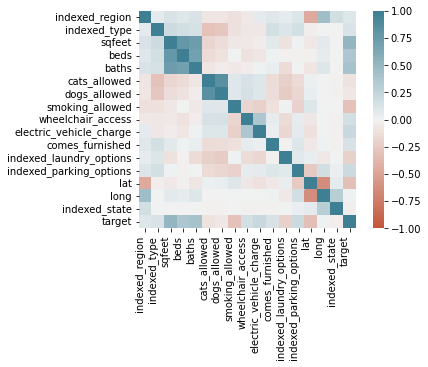

In [13]:
#matrice de corélation
import seaborn as sns
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
cols=data_num.columns[1:]
assembler = VectorAssembler(inputCols=data_num.columns[1:], outputCol=vector_col)
df_vector = assembler.transform(data_num).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
arr=matrix.collect()[0]["pearson({})".format(vector_col)].values.reshape(len(data_num.columns)-1,len(data_num.columns)-1)
ax = sns.heatmap(arr,vmin=-1, vmax=1, center=0,cmap=sns.diverging_palette(20, 220, n=200),square=True)
ax.set_xticklabels(cols,rotation=90,horizontalalignment='right')
ax.set_yticklabels(cols,rotation=0)


**Interprétation :**

On peut remarquer une certaine logique dans la corrélation des features, par exemple les colonnes *'sqfeet'*, *'beds'* et *'baths'* qui représentent la surface, le nombre de lits et le nombre de salle de bains sont très corrélées entre-elles.

On peut aussi voir que la tolérence aux chats s'accompagne aussi géréralement d'une tolérence aux chiens (et vice-versa).

#Vectorisation des Features

In [14]:
#Vectorisation des features
from pyspark.ml.feature import VectorAssembler

stages,c=[],[]
for col in data_num.columns[1:-1]:
  stages.append(VectorAssembler(inputCols=[col], outputCol="vector_"+col))
  
pipeline=Pipeline(stages=stages)
data_vect = pipeline.fit(data_num).transform(data_num)
data_vect = data_vect.select('id','vector_indexed_region', 'vector_indexed_type', 'vector_sqfeet', 'vector_beds', 'vector_baths', 'vector_cats_allowed', 'vector_dogs_allowed', 'vector_smoking_allowed', 'vector_wheelchair_access', 'vector_electric_vehicle_charge', 'vector_comes_furnished', 'vector_indexed_laundry_options', 'vector_indexed_parking_options', 'vector_lat', 'vector_long', 'vector_indexed_state','target')
data_vect.show()



+---+---------------------+-------------------+-------------+-----------+------------+-------------------+-------------------+----------------------+------------------------+------------------------------+----------------------+------------------------------+------------------------------+----------+--------------------+--------------------+------+
| id|vector_indexed_region|vector_indexed_type|vector_sqfeet|vector_beds|vector_baths|vector_cats_allowed|vector_dogs_allowed|vector_smoking_allowed|vector_wheelchair_access|vector_electric_vehicle_charge|vector_comes_furnished|vector_indexed_laundry_options|vector_indexed_parking_options|vector_lat|         vector_long|vector_indexed_state|target|
+---+---------------------+-------------------+-------------+-----------+------------+-------------------+-------------------+----------------------+------------------------+------------------------------+----------------------+------------------------------+------------------------------+--------

#Train Test Split

In [15]:
# Split Train Test

#Not Scaled NS
data_train_NS, data_test_NS = data_vect.randomSplit([0.8, 0.2],seed=42)
print("Not Scaled :")
print("Data train:",data_train_NS.count())
print("Data test:",data_test_NS.count())

Not Scaled :
Data train: 8034
Data test: 1942


#Standardisation (Moyenne, Ecart-type)

In [16]:
from pyspark.ml.feature import StandardScaler
#Standardisation des features
stages = []
for col in data_vect.columns[1:-1]:
  stages.append(StandardScaler(withMean=True, withStd=True, inputCol=col, outputCol=col+"_Scaled"))
  
pipeline=Pipeline(stages=stages)
"""
data_scaled = pipeline.fit(data_vect).transform(data_vect)
data_scaled = data_scaled.select('id','vector_indexed_region_Scaled', 'vector_indexed_type_Scaled', 'vector_sqfeet_Scaled', 'vector_beds_Scaled', 'vector_baths_Scaled', 'vector_cats_allowed_Scaled', 'vector_dogs_allowed_Scaled', 'vector_smoking_allowed_Scaled', 'vector_wheelchair_access_Scaled', 'vector_electric_vehicle_charge_Scaled', 'vector_comes_furnished_Scaled', 'vector_indexed_laundry_options_Scaled', 'vector_indexed_parking_options_Scaled', 'vector_lat_Scaled', 'vector_long_Scaled', 'vector_indexed_state_Scaled','target')
data_scaled.show()
"""

data_train_S = pipeline.fit(data_train_NS).transform(data_train_NS)
data_train_S = data_train_S.select('id','vector_indexed_region_Scaled', 'vector_indexed_type_Scaled', 'vector_sqfeet_Scaled', 'vector_beds_Scaled', 'vector_baths_Scaled', 'vector_cats_allowed_Scaled', 'vector_dogs_allowed_Scaled', 'vector_smoking_allowed_Scaled', 'vector_wheelchair_access_Scaled', 'vector_electric_vehicle_charge_Scaled', 'vector_comes_furnished_Scaled', 'vector_indexed_laundry_options_Scaled', 'vector_indexed_parking_options_Scaled', 'vector_lat_Scaled', 'vector_long_Scaled', 'vector_indexed_state_Scaled','target')
print("Data train Scaled :")
data_train_S.show()


Data train Scaled :
+---+----------------------------+--------------------------+--------------------+--------------------+--------------------+--------------------------+--------------------------+-----------------------------+-------------------------------+-------------------------------------+-----------------------------+-------------------------------------+-------------------------------------+--------------------+--------------------+---------------------------+------+
| id|vector_indexed_region_Scaled|vector_indexed_type_Scaled|vector_sqfeet_Scaled|  vector_beds_Scaled| vector_baths_Scaled|vector_cats_allowed_Scaled|vector_dogs_allowed_Scaled|vector_smoking_allowed_Scaled|vector_wheelchair_access_Scaled|vector_electric_vehicle_charge_Scaled|vector_comes_furnished_Scaled|vector_indexed_laundry_options_Scaled|vector_indexed_parking_options_Scaled|   vector_lat_Scaled|  vector_long_Scaled|vector_indexed_state_Scaled|target|
+---+----------------------------+----------------------

In [17]:
data_test_S = pipeline.fit(data_train_NS).transform(data_test_NS)
data_test_S = data_test_S.select('id','vector_indexed_region_Scaled', 'vector_indexed_type_Scaled', 'vector_sqfeet_Scaled', 'vector_beds_Scaled', 'vector_baths_Scaled', 'vector_cats_allowed_Scaled', 'vector_dogs_allowed_Scaled', 'vector_smoking_allowed_Scaled', 'vector_wheelchair_access_Scaled', 'vector_electric_vehicle_charge_Scaled', 'vector_comes_furnished_Scaled', 'vector_indexed_laundry_options_Scaled', 'vector_indexed_parking_options_Scaled', 'vector_lat_Scaled', 'vector_long_Scaled', 'vector_indexed_state_Scaled','target')
print("Data test Scaled :")
data_test_S.show()

Data test Scaled :
+---+----------------------------+--------------------------+--------------------+--------------------+--------------------+--------------------------+--------------------------+-----------------------------+-------------------------------+-------------------------------------+-----------------------------+-------------------------------------+-------------------------------------+--------------------+--------------------+---------------------------+------+
| id|vector_indexed_region_Scaled|vector_indexed_type_Scaled|vector_sqfeet_Scaled|  vector_beds_Scaled| vector_baths_Scaled|vector_cats_allowed_Scaled|vector_dogs_allowed_Scaled|vector_smoking_allowed_Scaled|vector_wheelchair_access_Scaled|vector_electric_vehicle_charge_Scaled|vector_comes_furnished_Scaled|vector_indexed_laundry_options_Scaled|vector_indexed_parking_options_Scaled|   vector_lat_Scaled|  vector_long_Scaled|vector_indexed_state_Scaled|target|
+---+----------------------------+-----------------------

In [18]:
print("Data Scaled :")
print("Train :",data_train_S.count())
print("Test :",data_test_S.count())

Data Scaled :
Train : 8034
Test : 1942


#Assemblage des vecteurs (VectorAssembler)

In [20]:
#Vector Assembler


from pyspark.ml.feature import VectorAssembler

#on met tous les features (sauf id et target sous forme de vecteur)

#DATA SCALED
va_s=VectorAssembler(inputCols=data_train_S.columns[1:-1], outputCol="features")

columns_data_S = data_train_S.columns

data_train_S = va_s.transform(data_train_S)
data_train_S = data_train_S.select('features','target')
data_test_S = va_s.transform(data_test_S)
data_test_S = data_test_S.select('features','target')

print("Data Vectorized Scaled")
print("Data train Colonnes :",data_train_S.columns)
data_train_S.show()

print("Data Test Colonnes :",data_test_S.columns)
data_test_S.show()


#DATA NOT SCALED
va_ns=VectorAssembler(inputCols=data_train_NS.columns[1:-1], outputCol="features")

columns_data_NS = data_train_NS.columns

data_train_NS = va_ns.transform(data_train_NS)
data_train_NS = data_train_NS.select('features','target')
data_test_NS = va_ns.transform(data_test_NS)
data_test_NS = data_test_NS.select('features','target')

print("Data Vectorized Not Scaled")
print("Data train Colonnes :",data_train_NS.columns)
data_train_NS.show()

print("Data Test Colonnes :",data_test_NS.columns)
data_test_NS.show()



Data Vectorized Scaled
Data train Colonnes : ['features', 'target']
+--------------------+------+
|            features|target|
+--------------------+------+
|[0.64992470765988...|  1148|
|[0.64992470765988...|  1200|
|[0.64992470765988...|  1095|
|[0.64992470765988...|   935|
|[0.64992470765988...|  1095|
|[0.64992470765988...|  1295|
|[0.64992470765988...|  1159|
|[0.64992470765988...|  1449|
|[0.64992470765988...|  1295|
|[0.64992470765988...|   982|
|[0.64992470765988...|  1495|
|[0.64992470765988...|  1899|
|[0.64992470765988...|  1075|
|[0.64992470765988...|  1495|
|[0.64992470765988...|   995|
|[0.64992470765988...|  1325|
|[0.64992470765988...|   895|
|[0.64992470765988...|  1975|
|[0.64992470765988...|  1595|
|[0.64992470765988...|  1045|
+--------------------+------+
only showing top 20 rows

Data Test Colonnes : ['features', 'target']
+--------------------+------+
|            features|target|
+--------------------+------+
|[0.64992470765988...|  1813|
|[0.64992470765988...|

#Grid Search

In [21]:
#Grid search pour trouver les hyper-parametres du RandomForestRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

#Evaluation Model
RMSEevaluator = RegressionEvaluator(predictionCol = 'prediction', labelCol = 'target', metricName = 'rmse')
MAEevaluator = RegressionEvaluator(predictionCol = 'prediction', labelCol = 'target', metricName = 'mae')
R2evaluator = RegressionEvaluator(predictionCol = 'prediction', labelCol = 'target', metricName = 'r2')


#Données non standardisées :

In [22]:
# Not scaled  NS
#création d'un modèle RandomForest
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'target', seed = 42)

#Grid Param
rfParamGrid = (ParamGridBuilder()
                .addGrid(rf.maxDepth, [2,5,10,20,30])
                .addGrid(rf.numTrees, [2,3,5,10,20])
                .build())

#CrossValidator 3 Folds
cv = CrossValidator(estimator = rf,
                    estimatorParamMaps = rfParamGrid,
                    evaluator = RMSEevaluator,
                    numFolds = 3)

rfModelOptim_NS = cv.fit(data_train_NS)
predictions_NS = rfModelOptim_NS.transform(data_test_NS)

print("Données Non Standardisées Non Réduites:")
rmse = []
rmse.append(RMSEevaluator.evaluate(predictions_NS))
print("RMSE :",rmse[-1])
mae = []
mae.append(MAEevaluator.evaluate(predictions_NS))
print("MAE :",mae[-1])
r2 = []
r2.append(R2evaluator.evaluate(predictions_NS))
print("R2 :",r2[-1])

Données Non Standardisées Non Réduites:
RMSE : 376.89224879308216
MAE : 178.9138525942324
R2 : 0.8339735242577129


In [23]:
from pyspark.mllib.linalg import DenseVector
saprseVector_featureImportanceNotScaled = rfModelOptim_NS.bestModel.featureImportances
saprseVector_featureImportanceNotScaled = DenseVector(saprseVector_featureImportanceNotScaled)

#Données satndardisées :

In [24]:
#Scaled  S
#création d'un modèle RandomForest
rf2 = RandomForestRegressor(featuresCol = 'features', labelCol = 'target', seed = 42)

#Grid Param
rfParamGrid = (ParamGridBuilder()
                .addGrid(rf2.maxDepth, [2,5,10,20,30])
                .addGrid(rf2.numTrees, [2,3,5,10,20])
                .build())

#CrossValidator 3 Folds
cv = CrossValidator(estimator = rf2,
                    estimatorParamMaps = rfParamGrid,
                    evaluator = RMSEevaluator,
                    numFolds = 3)

rfModelOptim = cv.fit(data_train_S)
predictions_S = rfModelOptim.transform(data_test_S)

print("Données Standardisées Non Réduites :")
print("Métriques d'évaluation: ")
rmse.append(RMSEevaluator.evaluate(predictions_S))
print("RMSE en utilisant des données réduite :",rmse[-1])
mae.append(MAEevaluator.evaluate(predictions_S))
print("MAE en utilisant des données réduite :",mae[-1])
r2.append(R2evaluator.evaluate(predictions_S))
print("R2 en utilisant des données réduite :",r2[-1])

Données Standardisées Non Réduites :
Métriques d'évaluation: 
RMSE en utilisant des données réduite : 363.1604119941535
MAE en utilisant des données réduite : 173.55479669637154
R2 en utilisant des données réduite : 0.8458512746727533


In [25]:
from pyspark.mllib.linalg import DenseVector
saprseVector_featureImportanceScaled = rfModelOptim.bestModel.featureImportances
saprseVector_featureImportanceScaled = DenseVector(saprseVector_featureImportanceScaled)

In [41]:
rfModelOptim.bestModel

RandomForestRegressionModel: uid=RandomForestRegressor_05b7a6f8a4a7, numTrees=20, numFeatures=16

In [43]:
rfModelOptim.bestModel.getMaxDepth()

30

#**Features Selection**



Après avoir éffectuer une cross-validation en utilisant un **RandomForestRegressor** sur des données **non standardisées** et des données **standardisées**, on a obtenu les **Features Importances** suivantes:





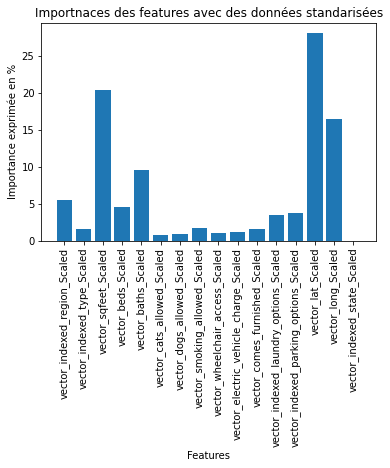

In [26]:
#Pour des données standardisées

import matplotlib.pyplot as plt


featureImportances = saprseVector_featureImportanceScaled

plt.bar(columns_data_S[1:-1], featureImportances*100)
plt.title("Importnaces des features avec des données standarisées")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance exprimée en %")
plt.show()


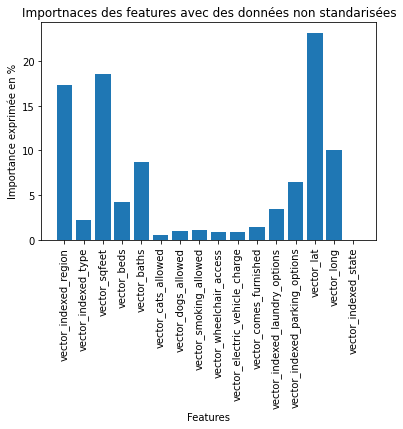

In [27]:
#Pour des données non standardisées


featureImportances = saprseVector_featureImportanceNotScaled

plt.bar(columns_data_NS[1:-1], featureImportances*100)
plt.title("Importnaces des features avec des données non standarisées")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance exprimée en %")
plt.show()



---



Après cette analyse, on peut voir qu'il y a des features qui sont plus descriminantes que d'autres dans la tache de régression :     

**region , sqfeet , beds , baths , parking_options, laundry_options, lat , long**

On va redécouper notre DataSet en ne gardant que ces colonnes et puis on va analyser les résultats en laçant un gridSearch avec un RandomForestRegressor sur ces données standardisées et non standardisées.

In [28]:
data_vect_FS = data_vect.select("vector_indexed_region", "vector_sqfeet", "vector_beds", "vector_baths","vector_indexed_laundry_options","vector_indexed_parking_options", "vector_lat", "vector_long", "target")
data_vect_FS.show()

+---------------------+-------------+-----------+------------+------------------------------+------------------------------+----------+--------------------+------+
|vector_indexed_region|vector_sqfeet|vector_beds|vector_baths|vector_indexed_laundry_options|vector_indexed_parking_options|vector_lat|         vector_long|target|
+---------------------+-------------+-----------+------------+------------------------------+------------------------------+----------+--------------------+------+
|                [4.0]|     [1078.0]|      [3.0]|       [2.0]|                         [0.0]|                         [0.0]| [39.5483]|          [-119.796]|  1148|
|                [4.0]|     [1001.0]|      [2.0]|       [2.0]|                         [2.0]|                         [0.0]| [39.5026]|          [-119.789]|  1200|
|                [4.0]|     [1683.0]|      [2.0]|       [2.0]|                         [0.0]|                         [1.0]| [39.6269]|          [-119.708]|  1813|
|               

#TRAIN TEST SPLIT

In [29]:
# train test split 

#données après une feature selection 
data_train_FS , data_test_FS = data_vect_FS.randomSplit([0.8,0.2], seed=42)
print("With Features Selection and No Standardization :")
print("Data train:",data_train_FS.count())
print("Data test:",data_test_FS.count())


With Features Selection and No Standardization :
Data train: 8034
Data test: 1942


#STANDARDISATION 

En utilisant la moyenne et l'équart-type

In [30]:
from pyspark.ml.feature import StandardScaler
#Standardisation des features
stages = []
for col in data_vect_FS.columns[:-1]:
  stages.append(StandardScaler(withMean=True, withStd=True, inputCol=col, outputCol=col+"_Scaled"))
  
pipeline=Pipeline(stages=stages)
data_train_FSS = pipeline.fit(data_train_FS).transform(data_train_FS)
data_train_FSS = data_train_FSS.select('vector_indexed_region_Scaled', 'vector_sqfeet_Scaled', 'vector_beds_Scaled', 'vector_baths_Scaled' ,'vector_indexed_laundry_options_Scaled','vector_indexed_parking_options_Scaled', 'vector_lat_Scaled', 'vector_long_Scaled','target')
data_train_FSS.show()

+----------------------------+--------------------+--------------------+--------------------+-------------------------------------+-------------------------------------+--------------------+--------------------+------+
|vector_indexed_region_Scaled|vector_sqfeet_Scaled|  vector_beds_Scaled| vector_baths_Scaled|vector_indexed_laundry_options_Scaled|vector_indexed_parking_options_Scaled|   vector_lat_Scaled|  vector_long_Scaled|target|
+----------------------------+--------------------+--------------------+--------------------+-------------------------------------+-------------------------------------+--------------------+--------------------+------+
|        [-1.180220651197663]|[-2.1325262756830...|[1.3700332955420387]|[0.8108678445402753]|                 [-0.7770007874131...|                 [-0.8088093010192...|[0.7599462086812971]|[-0.531383791679752]|  2025|
|        [-1.180220651197663]|[-1.8903009825091...|[0.22598927762448...|[1.6284522149012899]|                 [-0.7770007874

In [31]:
#On standardise les données de test selon la moyennes et les écarts-types des données de train
data_test_FSS = pipeline.fit(data_train_FS).transform(data_test_FS)
data_test_FSS = data_test_FSS.select('vector_indexed_region_Scaled', 'vector_sqfeet_Scaled', 'vector_beds_Scaled', 'vector_baths_Scaled' ,'vector_indexed_parking_options_Scaled', 'vector_indexed_laundry_options_Scaled', 'vector_lat_Scaled', 'vector_long_Scaled','target')
data_test_FSS.show()

+----------------------------+--------------------+--------------------+--------------------+-------------------------------------+-------------------------------------+--------------------+--------------------+------+
|vector_indexed_region_Scaled|vector_sqfeet_Scaled|  vector_beds_Scaled| vector_baths_Scaled|vector_indexed_parking_options_Scaled|vector_indexed_laundry_options_Scaled|   vector_lat_Scaled|  vector_long_Scaled|target|
+----------------------------+--------------------+--------------------+--------------------+-------------------------------------+-------------------------------------+--------------------+--------------------+------+
|        [-1.180220651197663]|[-1.7207432772874...|[-0.9180547402930...|[-0.8243008961817...|                    [2.4858916366857]|                 [-0.7770007874131...|[0.8005615950720754]|[-0.6838086986087...|  1050|
|        [-1.180220651197663]|[-1.4102544924008...|[-0.9180547402930...|[-0.8243008961817...|                 [0.83854116783

In [32]:
#données après une standardisation et une réduction de dimensions

print("With Features Selection and Standardization :")
print("Data train:",data_train_FSS.count())
print("Data test:",data_test_FSS.count())


With Features Selection and Standardization :
Data train: 8034
Data test: 1942


# Vectorisation des données

In [33]:
#Vector Assembler

from pyspark.ml.feature import VectorAssembler

#on met tous les features sauf target sous forme de vecteur

#DATA SCALED
va_s=VectorAssembler(inputCols=data_train_FSS.columns[:-1], outputCol="features")

data_train_FSS = va_s.transform(data_train_FSS)
data_test_FSS = va_s.transform(data_test_FSS)
data_train_FSS = data_train_FSS.select('features','target')
data_test_FSS = data_test_FSS.select('features','target')

print("Data Vectorised train test with features selection and standardization :")
print("Colonnes :",data_train_FSS.columns)
print("Train")
data_train_FSS.show()
print("Test")
data_test_FSS.show()

#DATA NOT SCALED
va_s=VectorAssembler(inputCols=data_train_FS.columns[:-1], outputCol="features")

data_train_FS = va_s.transform(data_train_FS)
data_test_FS = va_s.transform(data_test_FS)
data_train_FS = data_train_FS.select('features','target')
data_test_FS = data_test_FS.select('features','target')

print("Data Vectorised train test with features selection and without standardization :")
print("Colonnes :",data_train_FS.columns)
print("Train")
data_train_FS.show()
print("Test")
data_test_FS.show()


Data Vectorised train test with features selection and standardization :
Colonnes : ['features', 'target']
Train
+--------------------+------+
|            features|target|
+--------------------+------+
|[-1.1802206511976...|  2025|
|[-1.1802206511976...|  1845|
|[-1.1802206511976...|   650|
|[-1.1802206511976...|   700|
|[-1.1802206511976...|   700|
|[-1.1802206511976...|  1200|
|[-1.1802206511976...|   860|
|[-1.1802206511976...|   975|
|[-1.1802206511976...|  1300|
|[-1.1802206511976...|   945|
|[-1.1802206511976...|  1747|
|[-1.1802206511976...|  1650|
|[-1.1802206511976...|  1600|
|[-1.1802206511976...|  1600|
|[-1.1802206511976...|  1600|
|[-1.1802206511976...|  1200|
|[-1.1802206511976...|  1200|
|[-1.1802206511976...|  1385|
|[-1.1802206511976...|   995|
|[-1.1802206511976...|   995|
+--------------------+------+
only showing top 20 rows

Test
+--------------------+------+
|            features|target|
+--------------------+------+
|[-1.1802206511976...|  1050|
|[-1.18022065119

#Grid Search 

In [34]:
#Grid search pour trouver les hyper-parametres du RandomForestRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

#Evaluation Model
RMSEevaluator = RegressionEvaluator(predictionCol = 'prediction', labelCol = 'target', metricName = 'rmse')
MAEevaluator = RegressionEvaluator(predictionCol = 'prediction', labelCol = 'target', metricName = 'mae')
R2evaluator = RegressionEvaluator(predictionCol = 'prediction', labelCol = 'target', metricName = 'r2')

#RandomForestRegressor sur des données non standardisées après une features selection

In [35]:
#Data reduced not scaled  FS
#création d'un modèle RandomForest
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'target', seed = 42)

#Grid Param
rfParamGrid = (ParamGridBuilder()
                .addGrid(rf.maxDepth, [2,5,10,20,30])
                .addGrid(rf.numTrees, [2,3,5,10,20])
                .build())

#CrossValidator 3 Folds
cv = CrossValidator(estimator = rf,
                    estimatorParamMaps = rfParamGrid,
                    evaluator = RMSEevaluator,
                    numFolds = 3)

rfModelOptim_FS = cv.fit(data_train_FS)
predictions_FS = rfModelOptim_FS.transform(data_test_FS)

print("Données Non Standardisées Réduites :")
rmse.append(RMSEevaluator.evaluate(predictions_FS))
print("RMSE :",rmse[-1])
mae.append(MAEevaluator.evaluate(predictions_FS))
print("MAE :",mae[-1])
r2.append(R2evaluator.evaluate(predictions_FS))
print("R2 :",r2[-1])

Données Non Standardisées Réduites :
RMSE : 400.15733037116104
MAE : 192.95498869724634
R2 : 0.8325237554694924


#RandomForestRegressor sur des données standardisées après une features selection

In [36]:
#Data reduced scaled  FSS
#création d'un modèle RandomForest
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'target', seed = 42)

#Grid Param
rfParamGrid = (ParamGridBuilder()
                .addGrid(rf.maxDepth, [2,5,10,20,30])
                .addGrid(rf.numTrees, [2,3,5,10,20])
                .build())

#CrossValidator 3 Folds
cv = CrossValidator(estimator = rf,
                    estimatorParamMaps = rfParamGrid,
                    evaluator = MAEevaluator,
                    numFolds = 3)

rfModelOptim_FSS = cv.fit(data_train_FSS)
predictions_FSS = rfModelOptim_FSS.transform(data_test_FSS)

print("Données Standardisées Réduites:")
rmse.append(RMSEevaluator.evaluate(predictions_FSS))
print("RMSE :",rmse[-1])
mae.append(MAEevaluator.evaluate(predictions_FSS))
print("MAE :",mae[-1])
r2.append(R2evaluator.evaluate(predictions_FSS))
print("R2 :",r2[-1])

Données Standardisées Réduites:
RMSE : 398.2316580334565
MAE : 195.7130984843102
R2 : 0.8341317648944409


#Analyse du meilleur Modèle :

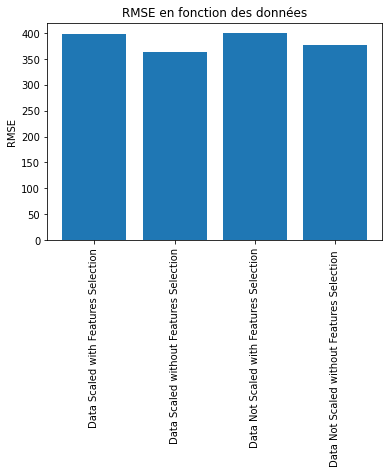

In [37]:
#RMSE
import matplotlib.pyplot as plt

#y = [567.6235590728907,1023.219513322455,1249.1763282665206,1241.1807291207506]
y = [rmse[3], rmse[1], rmse[2], rmse[0]]
x = ['Data Scaled with Features Selection','Data Scaled without Features Selection', 'Data Not Scaled with Features Selection', 'Data Not Scaled without Features Selection ']
plt.bar(x,y)
plt.xticks(rotation=90)
plt.ylabel("RMSE")
plt.title("RMSE en fonction des données")
plt.show()


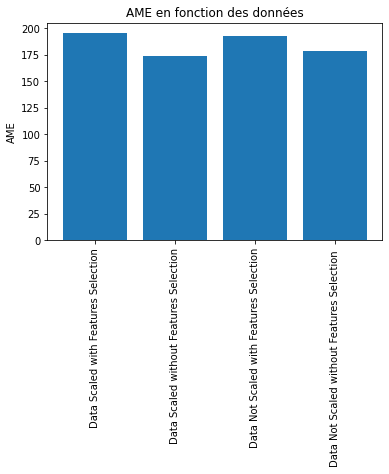

In [38]:
#MAE
#y = [284.5878185876112,550.9610951245314,523.6365681377617,575.2361272568392]
y = [mae[3], mae[1], mae[2], mae[0]]
x = ['Data Scaled with Features Selection','Data Scaled without Features Selection', 'Data Not Scaled with Features Selection', 'Data Not Scaled without Features Selection ']
plt.bar(x,y)
plt.xticks(rotation=90)
plt.ylabel("AME")
plt.title("AME en fonction des données")
plt.show()

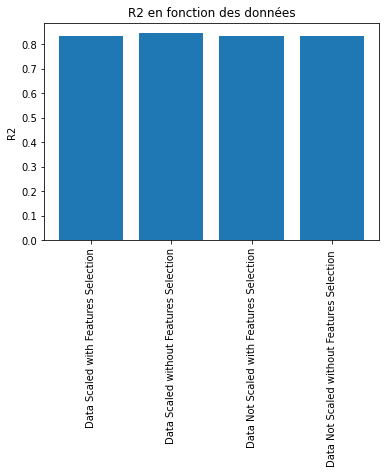

In [39]:
#R2
#y = [0.7266081096248757,0.12434526884358699,-0.3240741127984852,-0.28844332220165203]
y = [r2[3], r2[1], r2[2], r2[0]]
x = ['Data Scaled with Features Selection','Data Scaled without Features Selection', 'Data Not Scaled with Features Selection', 'Data Not Scaled without Features Selection ']
plt.bar(x,y)
plt.xticks(rotation=90)
plt.ylabel("R2")
plt.title("R2 en fonction des données")
plt.show()


**La RMSE, AME et R2 montrent de bons scores avec les 4 configurations de  données. Mais on peut remarquer un score légerement au dessus avec des données standardisées mais non réduites**

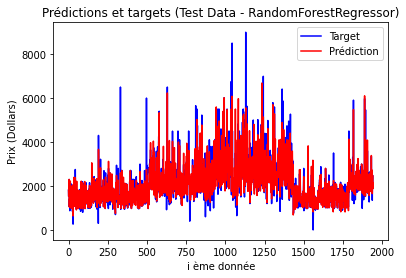

In [40]:
#Plot test target et prediction target pour le meilleur modèle

target = data_test_S.select('target')
target = target.toPandas().values
target = target.reshape(1,-1)[0]

predictions = predictions_S.select('prediction')
predictions = predictions.toPandas().values
predictions = predictions.reshape(1,-1)[0]

plt.plot([i for i in range(len(target))],target,color='blue',label="Target")
plt.xlabel("i ème donnée")
plt.ylabel("Prix (Dollars)")
plt.plot([i for i in range(len(predictions))],predictions,color='red',label="Prédiction")
plt.title("Prédictions et targets (Test Data - RandomForestRegressor)")
plt.legend()
plt.show()


On remarque que notre modèle prédit très bien les données en Test (Avec la configuration de données standardisées et non réduites). 

RandomForestRegressor: 

NbTrees = 20

NbFeatures = 16 (region , type, sqfeet, beds , baths , cats_allowed, dogs_allowed, smoking_allowed, wheelchain_access, electric_vehicle_charge, comes_furnished, laundry_options ,parking_options , lat , long, state)


MaxDepth = 30

Le RandomForestRegressor se base sur l'utilisation d'arbre de régression, on va donc appliquer un DecisionTreeRegressor et un LinearRegression. Comme les résultats obtenus sont plus au moins similaires pour les 4 configurations de données on choisit donc d'appliquer ces algorithmes sur les données standardisées et réduites pour minimiser le temps de calcul des GridSearch, puis analyser les résultats.

#DecisionTreeRegressor sur les données standardisées et réduites :

In [44]:
#Data reduced scaled  FSS
#création d'un modèle RandomForest
from pyspark.ml.regression import DecisionTreeRegressor

dtr = DecisionTreeRegressor(featuresCol = 'features', labelCol = 'target', predictionCol='prediction' ,seed = 42)

#Grid Param
dtrParamGrid = (ParamGridBuilder()
                .addGrid(dtr.maxDepth, [2,3,4,5,10,20,30])
                .build())

#CrossValidator 3 Folds
cv = CrossValidator(estimator = dtr,
                    estimatorParamMaps = dtrParamGrid,
                    evaluator = MAEevaluator,
                    numFolds = 3)

rfModelOptim = cv.fit(data_train_FSS)
predictions_FSS = rfModelOptim.transform(data_test_FSS)

print("FS:")
print("RMSE :",RMSEevaluator.evaluate(predictions_FSS))
print("MAE :",MAEevaluator.evaluate(predictions_FSS))
print("R2 :",R2evaluator.evaluate(predictions_FSS))

FS:
RMSE : 465.6877001865398
MAE : 208.54693935410577
R2 : 0.7731800791401022


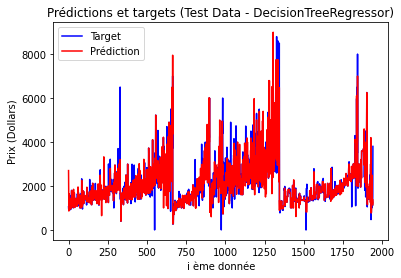

In [45]:
#Plot test target et prediction target pour DecisionTreeRegressor

target = data_test_FSS.select('target')
target = target.toPandas().values
target = target.reshape(1,-1)[0]

predictions = predictions_FSS.select('prediction')
predictions = predictions.toPandas().values
predictions = predictions.reshape(1,-1)[0]

plt.plot([i for i in range(len(target))],target,color='blue',label="Target")
plt.xlabel("i ème donnée")
plt.ylabel("Prix (Dollars)")
plt.plot([i for i in range(len(predictions))],predictions,color='red',label="Prédiction")
plt.title("Prédictions et targets (Test Data - DecisionTreeRegressor)")
plt.legend()
plt.show()


#LinearRegression sur les données standardisées et réduites :

In [48]:
#Data reduced scaled  FSS
#création d'un modèle LinearRegression
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol = 'target', predictionCol='prediction' )

#Grid Param
lrParamGrid = (ParamGridBuilder()
                .addGrid(lr.maxIter, [100,200])
                .addGrid(lr.loss , ['squaredError','huber'])
                .addGrid(lr.regParam, [0,1,3,5])
                .build())

#CrossValidator 3 Folds
cv = CrossValidator(estimator = lr,
                    estimatorParamMaps = lrParamGrid,
                    evaluator = RMSEevaluator,
                    numFolds = 3)

lrModelOptim = cv.fit(data_train_FSS)
predictions_FSS = lrModelOptim.transform(data_test_FSS)

print("FSS:")
print("RMSE :",RMSEevaluator.evaluate(predictions_FSS))
print("MAE :",MAEevaluator.evaluate(predictions_FSS))
print("R2 :",R2evaluator.evaluate(predictions_FSS))

FSS:
RMSE : 720.6513829455556
MAE : 480.0266124895345
R2 : 0.456822079022169


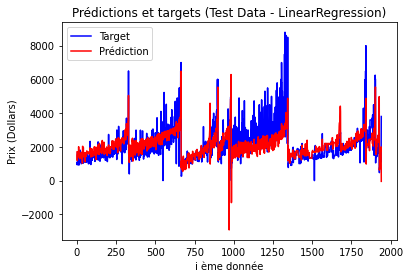

In [49]:
#Plot test target et prediction target pour LinearRegression

target = data_test_FSS.select('target')
target = target.toPandas().values
target = target.reshape(1,-1)[0]

predictions = predictions_FSS.select('prediction')
predictions = predictions.toPandas().values
predictions = predictions.reshape(1,-1)[0]

plt.plot([i for i in range(len(target))],target,color='blue',label="Target")
plt.xlabel("i ème donnée")
plt.ylabel("Prix (Dollars)")
plt.plot([i for i in range(len(predictions))],predictions,color='red',label="Prédiction")
plt.title("Prédictions et targets (Test Data - LinearRegression)")
plt.legend()
plt.show()

#Le modèle optimal :
**En comparant les résultats précédents sur les métriques RMSE, MAE et R2, le RandomForestRegressor est de loin le modèle le plus performant sur les données standardisées et réduites.**

**Pour conclure, on peut choisir le RandomForestRegressor comme modèle pour prédire les loyers de notre dataset Housing.**

